In [6]:
""" Example to analyze Desroziers uncertainty from file """

import os,sys
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

""" Test file """
f = '/raid60/scratch/federico/DESROZIERS_MARCH2021/0-20000-0-82930_CEUAS_merged_v1.nc'
STATION = f.split('/')[-1].split('_CEUAS')[0]

# NB do not use with very large station! Requires a lot of time to create dataframe 
df_a    = xr.open_dataset(f, engine = 'h5netcdf' , group = 'advanced_uncertainty', decode_times = True).to_dataframe()
df_obs  = xr.open_dataset(f, engine = 'h5netcdf' , group = 'observations_table', decode_times = True).to_dataframe()
df_era5 = xr.open_dataset(f, engine = 'h5netcdf' , group = 'era5fb', decode_times = True).to_dataframe()


df_a['date_time'] = df_obs['date_time']
df_a['observation_value'] = df_obs['observation_value']
df_a['observed_variable'] = df_obs['observed_variable']
df_a['z_coordinate'] = df_obs['z_coordinate']
df_a['biascorr@body'] = df_era5['biascorr@body']

df_a['an_depar@body'] = df_era5['an_depar@body']
df_a['fg_depar@body'] = df_era5['fg_depar@body']

""" Selecting a date """
DATE = '1986-08-24T12:00:00'
dt = np.datetime64(DATE)

DF = df_a.loc[ (df_a['date_time'] == dt) ]

#a= DF.loc[ DF['observed_variable'] == 107 ][['date_time','desroziers_30','z_coordinate','num_30','observation_value']]
#print(a )

#plt.plot(DF['date_time'], DF['desroziers_30'])
#plt.show()



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [31]:
def plot_series(df_in= '', station='', vars = [], what = 'des', zoom = False):
    import matplotlib.gridspec as gridspec
    #plt.plot(DF['date_time'], DF['desroziers_30'])
    text = ''
    fs = 15 # fontsize
    dic = { 85 : {'x':'Temperature [K]'       , 'y': 'Pressure [hPa]' , 'ylim': (180,340), 'ylimdes': (0,14) } ,
            #106 : {'x': 'Wind from Direction'  , 'y': 'Pressure [hPa]', 'ylim': (180,340), 'ylimdes': (0,14) },
            107 : {'x': 'Wind Speed [m/s] '    , 'y': 'Pressure [hPa]', 'ylim': (0,100), 'ylimdes': (0,14) },
         
            104 : {'x': 'Wind u-component [m/s] '    , 'y': 'Pressure [hPa]', 'ylim': (-50,50), 'ylimdes': (0,14) },
            105 : {'x': 'Wind v-component [m/s] '    , 'y': 'Pressure [hPa]', 'ylim': (-50,50), 'ylimdes': (0,14) },

          }
    std_plevs    = [1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 70000, 85000, 92500, 100000]
    
    
    def remove_outliers(x,y):
        return 0
    
    for v in vars:
        
        fig = plt.figure(figsize=(15,15), constrained_layout=True)
        fig.suptitle('Timeseries for ' + dic[v]['x'] + ' - Station ' + station, y = 0.93, fontsize = 20 )
        spec = gridspec.GridSpec(ncols=4, nrows=4)

        df = df_in.loc[ df_in['observed_variable'] == v ]

        axs = []
        
        for p,num in zip(std_plevs , range(1,17) ):
            a= df.loc[ df['z_coordinate'] == p ]

            x   = a['date_time']
            obs = a['observation_value']
            y30 = a['desroziers_30']
            y90 = a['desroziers_90']
            y180 = a['desroziers_180']
            an = a['an_depar@body']
            fg = a['fg_depar@body']
   
            #t30 = a['num_30']

            axs.append(fig.add_subplot(spec[num -1]) )
            ax = axs[-1]
            
            #ax.plot([-10000],[-10000] label = 'Des. 30 [' + str(p) + ' hPa]', color = 'orange')
            ax.set_title( '[' + str(p) + ' hPa]' )
            ax.plot(x,obs, label = 'Obs', color = 'lightgray')
            if num ==1:
                ax.legend(fontsize = 9)
            #ax.grid(ls=':' , color = 'lightgray')
            ax.set_xticks([])
            if num not in [1,5,9,13]:
                ax.set_yticks([])
                
            ax.tick_params(axis='x', rotation=45)
            
            ax2=ax.twinx()
            if what == 'des':
                ax2.plot(x,y30,  color = 'orange'    , label = 'Des. 30'  )
                ax2.plot(x,y90,  color = 'lime'      , label = 'Des. 90'  )
                ax2.plot(x,y180, color = 'slateblue' , label = 'Des. 180' )
                ax2.set_ylim(dic[v]['ylimdes'])
            else:
                ax2.plot(x,an, color = 'red', label = 'Analysis Dep.'   )
                ax2.plot(x,fg, color = 'blue', label = 'Background Dep.' )
                ax2.set_ylim((-10,10))

            if num ==1:
                ax2.legend(fontsize = 9)
            if num not in [4,8,12,16]:
                ax2.set_yticks([])
            if num in  [4,8,12,16]:
                if what == 'des':
                    ax2.set_ylabel('Uncertainty', fontsize = fs)
                else:
                    ax2.set_ylabel('Departure', fontsize = fs)

            if num in [1,5,9,13]:
                ax.set_ylabel('Observations', fontsize = fs)
                
            if num <= 12:
                ax2.set_xticks([])
            ax2.set_xlim(np.datetime64('1978-01-01T00:00:00'),np.datetime64('1990-01-01T00:00:00') )
            if zoom:
                ax2.set_xlim(np.datetime64('1982-01-01T00:00:00'),np.datetime64('1984-01-01T00:00:00') )
                text = 'zoom'
            ax.set_ylim(dic[v]['ylim'])

    plt.savefig('Plots/series_' + str(v) + '_' + what + '_' + text + '.png' , dpi = 150)
    plt.show()
    plt.close()
 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


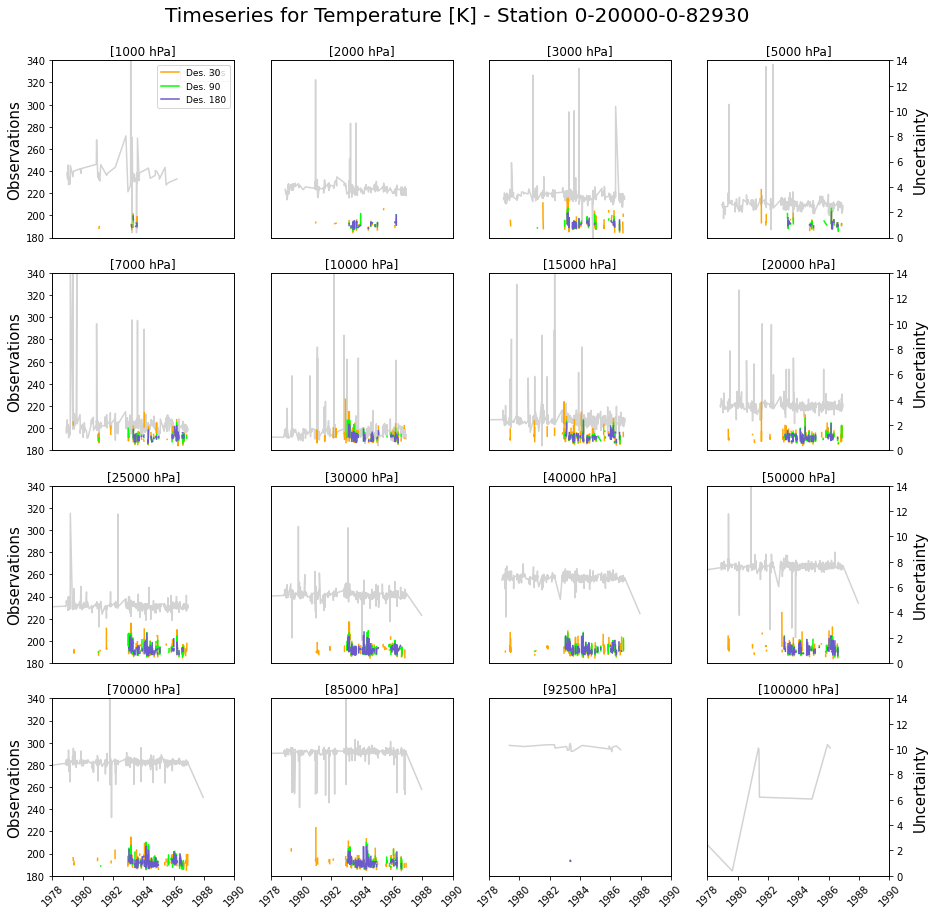

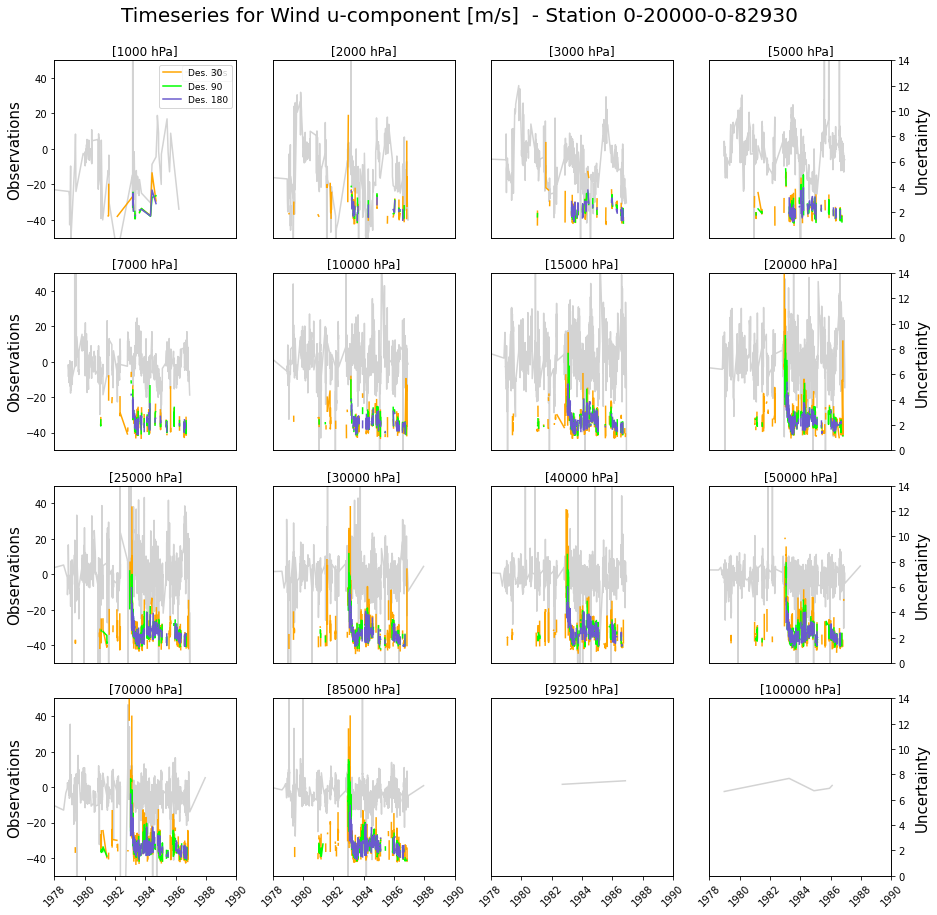

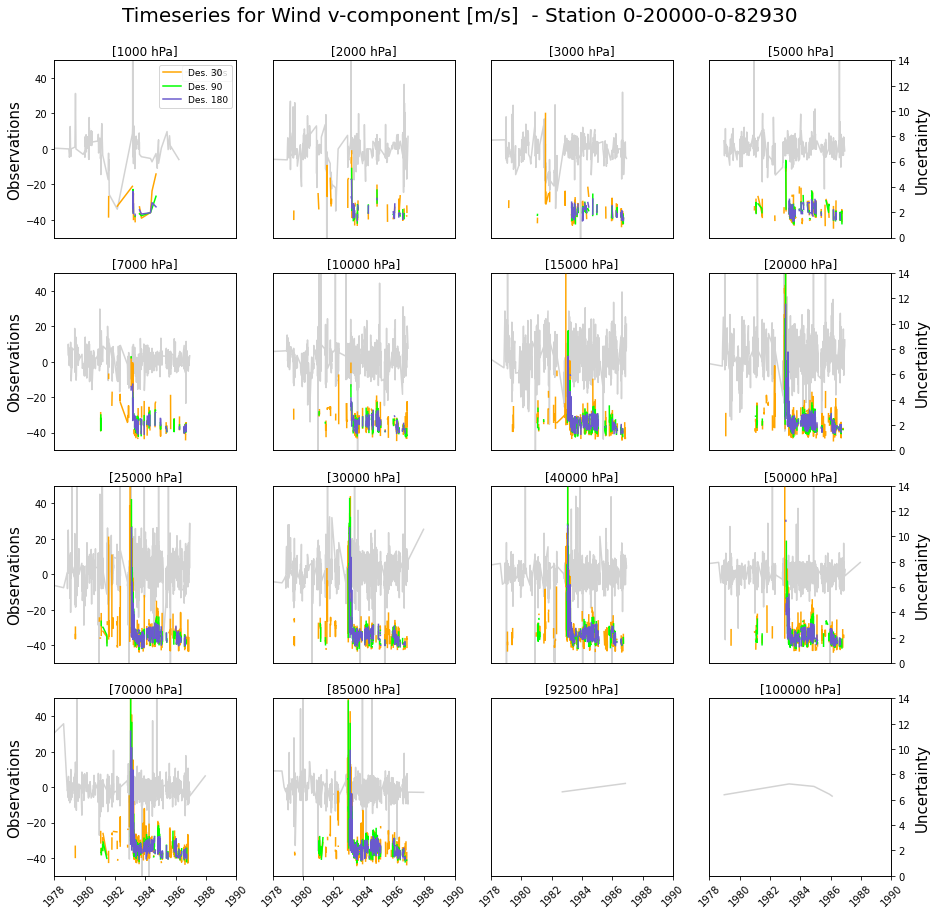

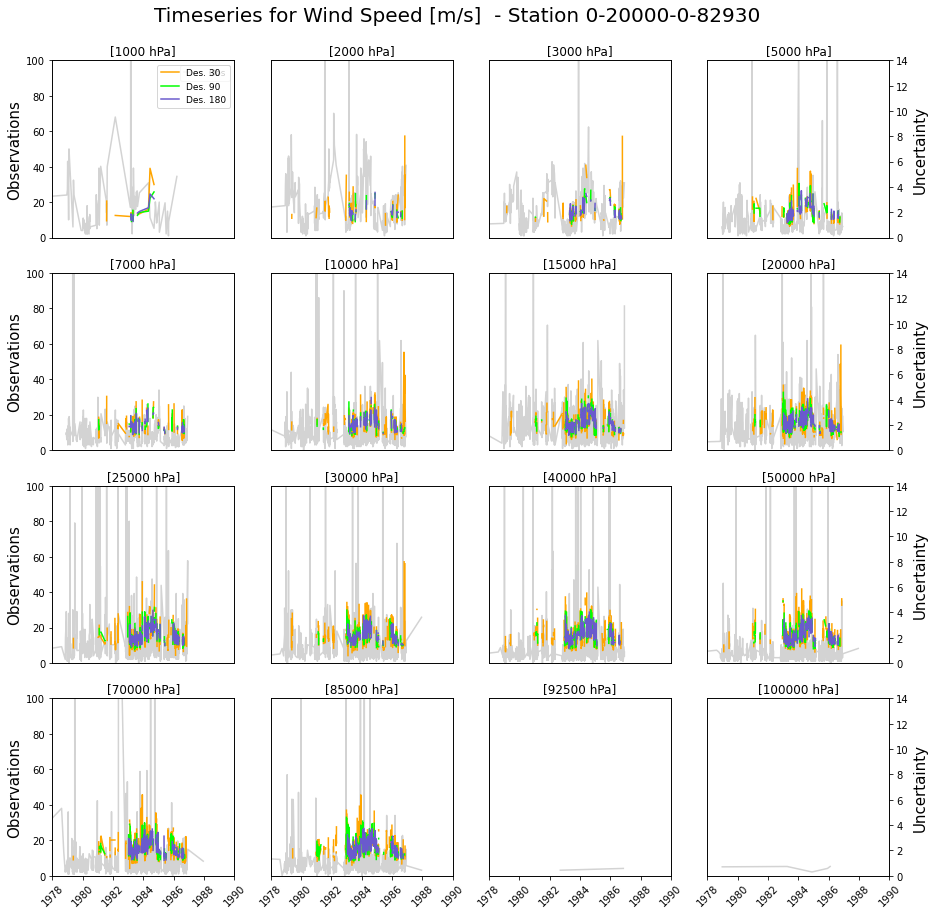

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


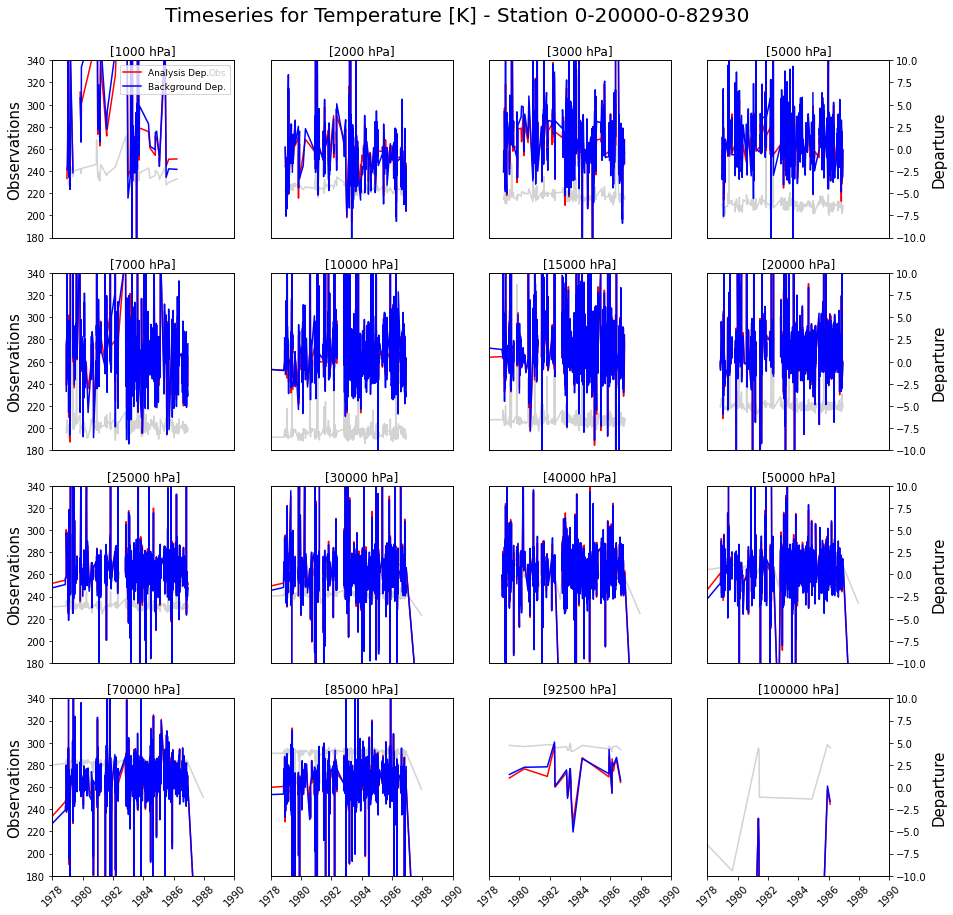

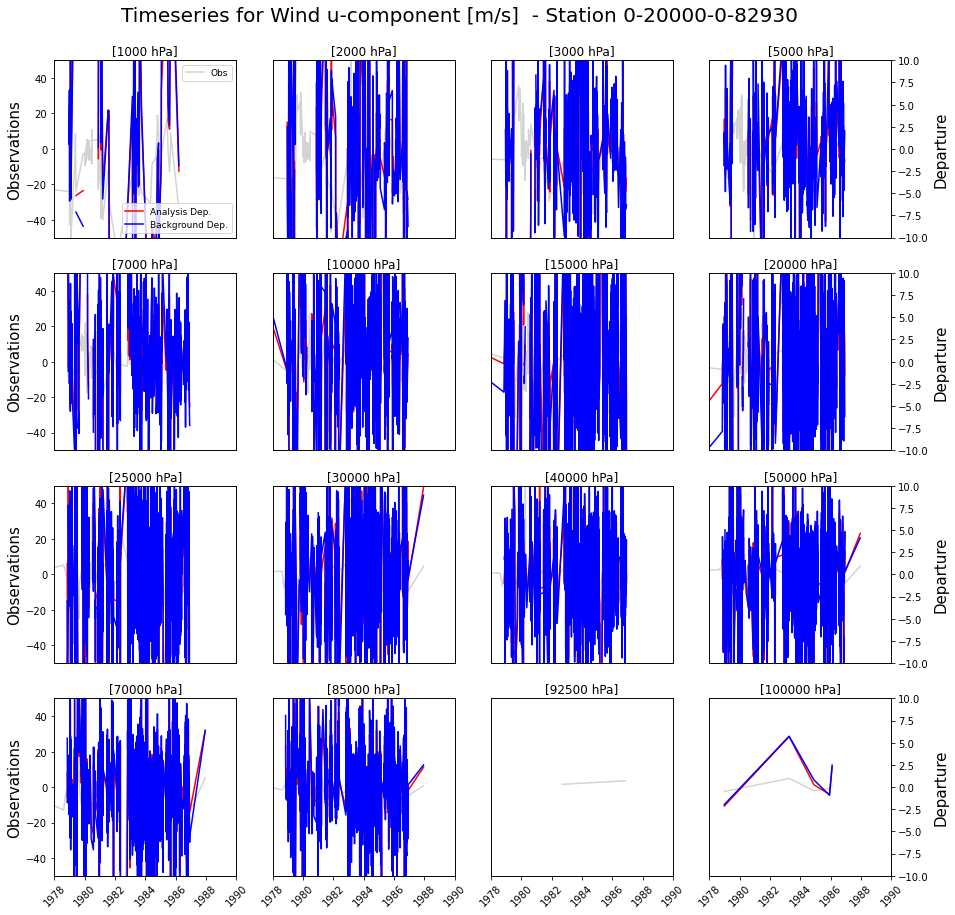

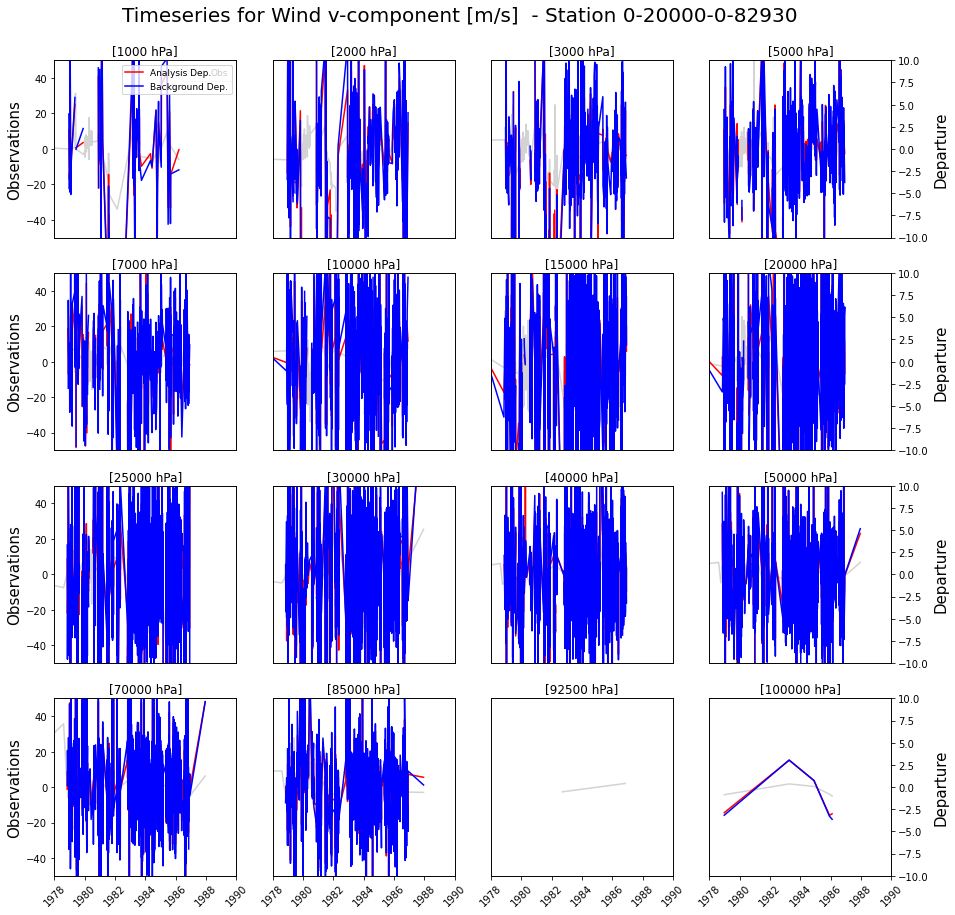

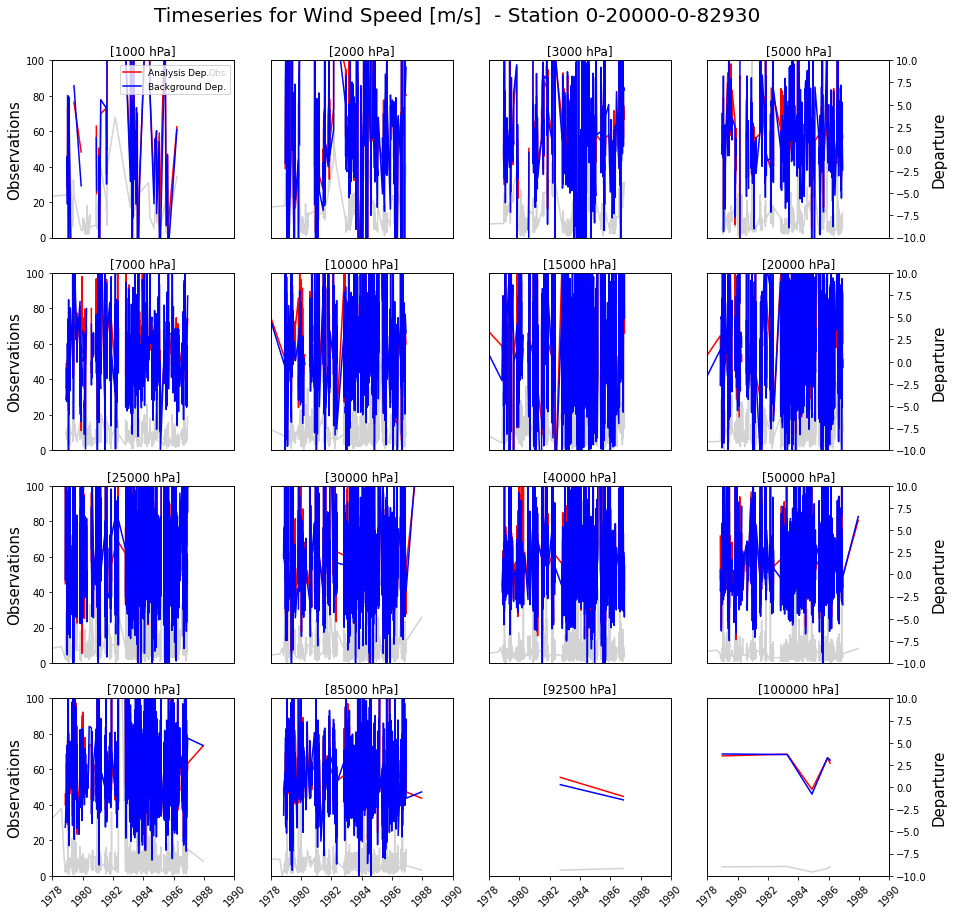

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


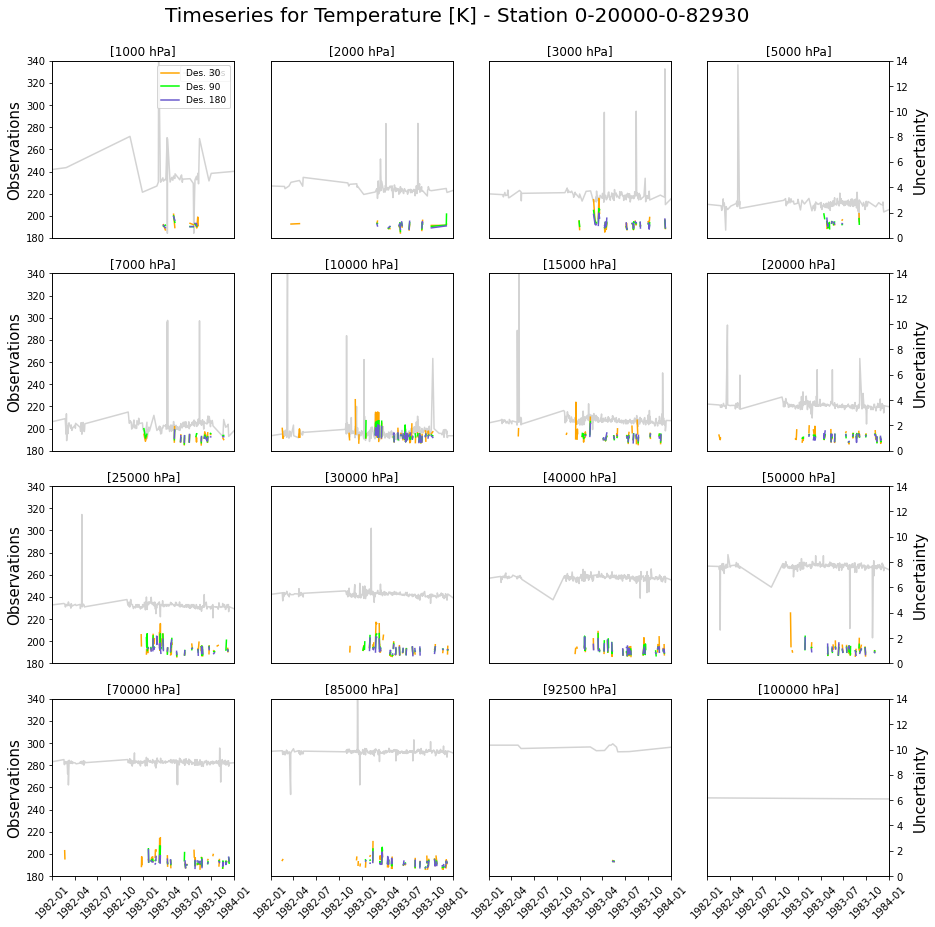

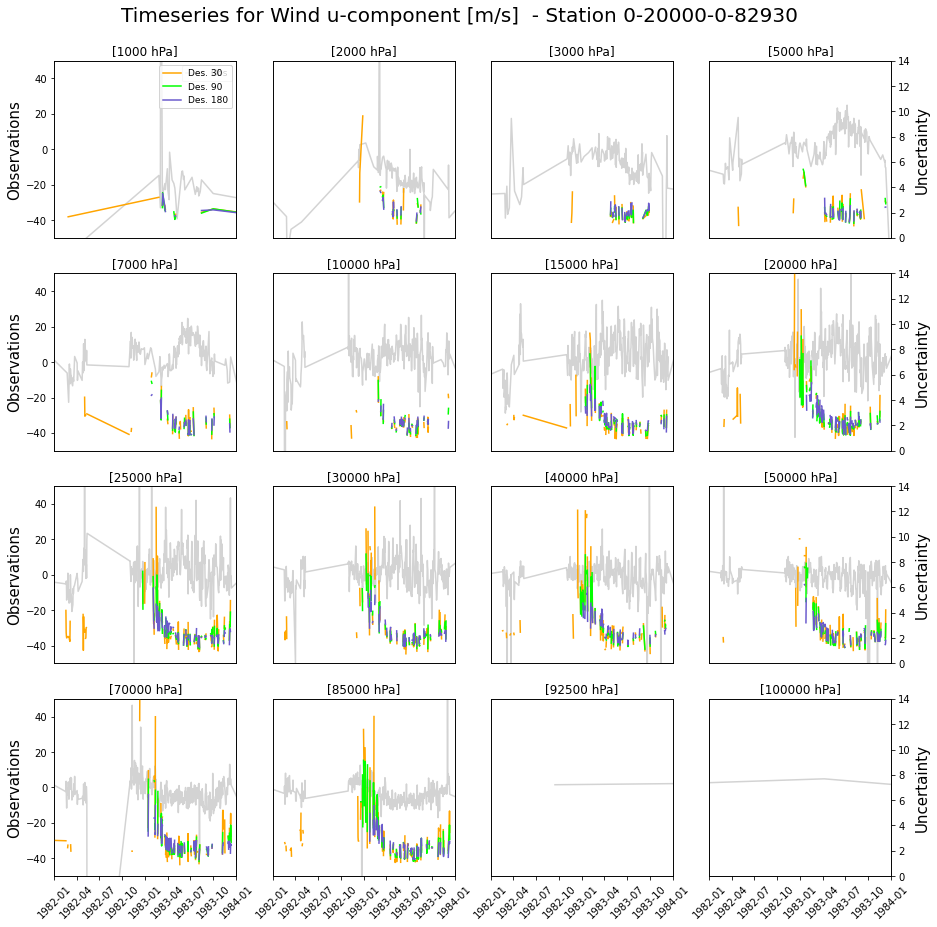

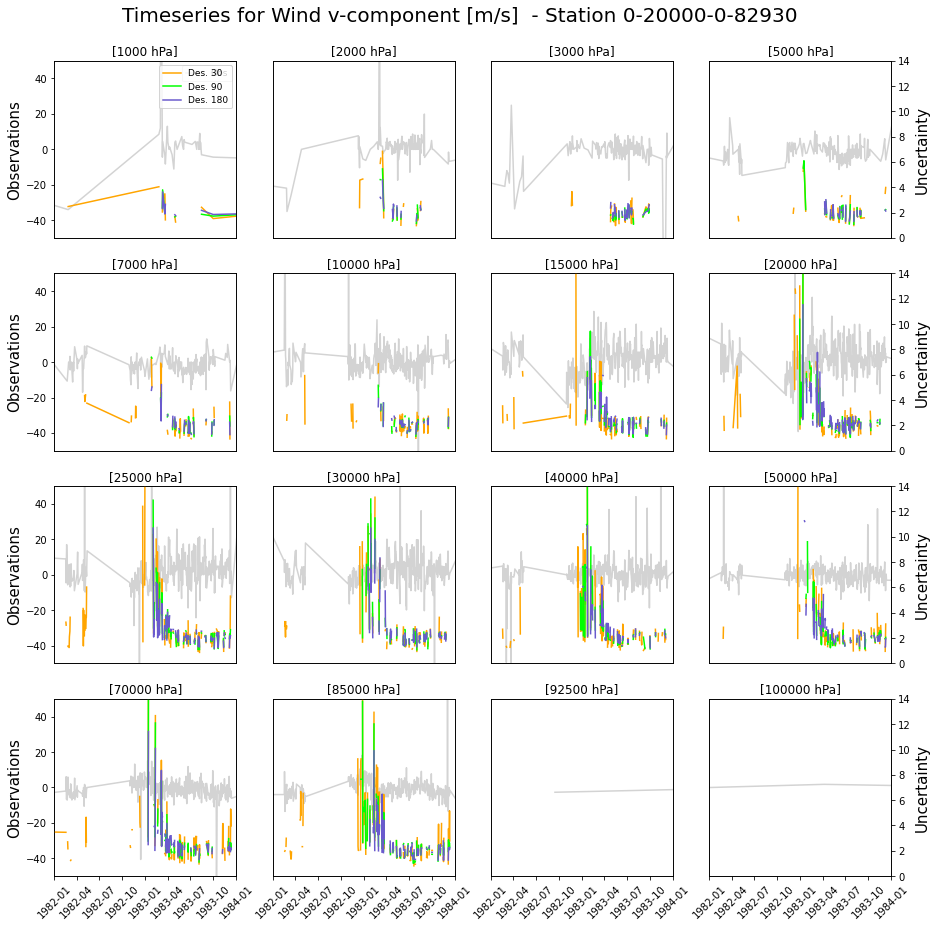

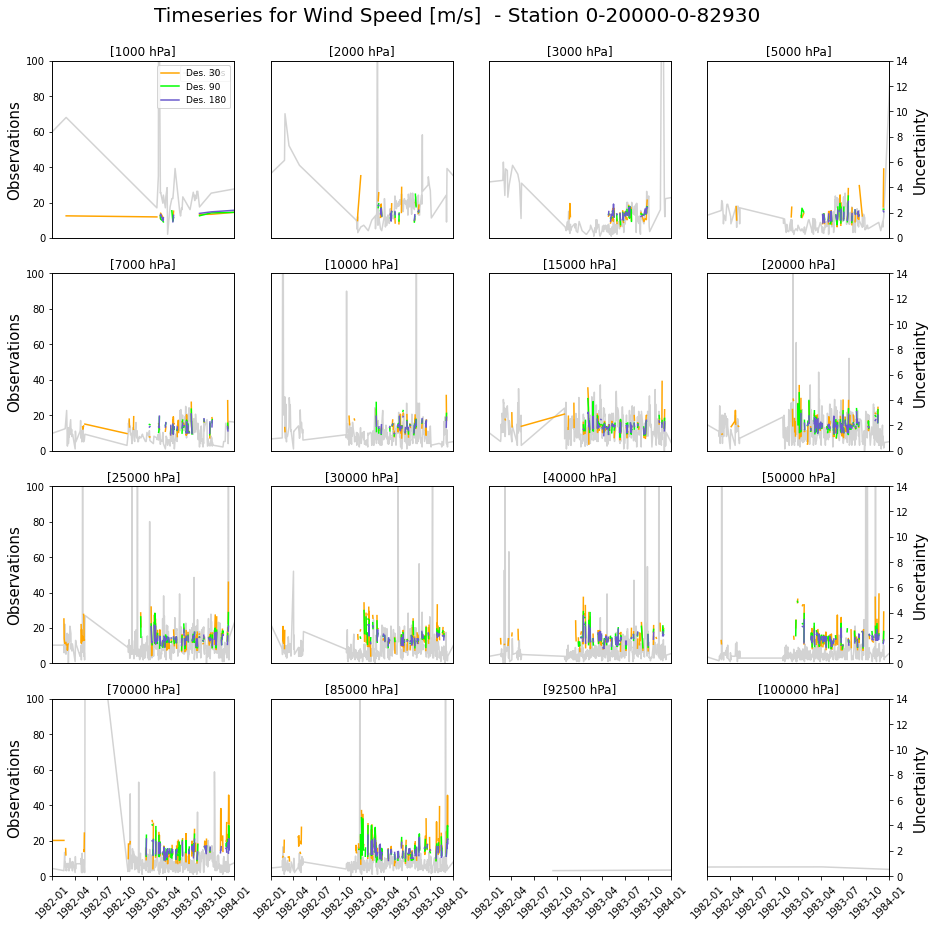

In [32]:
series = plot_series(df_in=df_a, station=STATION, vars = [85,104,105,107]               )
series = plot_series(df_in=df_a, station=STATION, vars = [85,104,105,107], what = 'dep' )
series = plot_series(df_in=df_a, station=STATION, vars = [85,104,105,107], zoom = True  )

In [33]:
def plot_profile(df_in='', date='', station='', vars = [], zoom = False ):
    
    dic = { 85 : {'x':'Temperature [K]'       , 'y': 'Pressure [hPa]'} ,
            106 : {'x': 'Wind from Direction'  , 'y': 'Pressure [hPa]'},
            107 : {'x': 'Wind Speed [m/s] '    , 'y': 'Pressure [hPa]'},
         
            104 : {'x': 'Wind u-component [m/s] '    , 'y': 'Pressure [hPa]'},
            105 : {'x': 'Wind v-component [m/s] '    , 'y': 'Pressure [hPa]'},

          }
    
    
    
    std_plevs    = [1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 70000, 85000, 92500, 100000]
        
    for v in vars:
        """ Selecting the variable temperature """
        ind = np.where (df_in['observed_variable'][:]==v)[0]
        df = df_in.iloc[ind]
        #print(df)
        #print(df[['date_time','desroziers_30','z_coordinate']])
        temp, bias, press, adj = [], [], [], []
        des_30, des_60, des_90, des_180 = [], [], [], []
        des_30_p, des_30_m = [], []
        des_60_p, des_60_m = [], []
        des_90_p, des_90_m = [], []
        des_180_p, des_180_m = [], []

        for p in std_plevs:
            ind = np.where ( df['z_coordinate'] == p )[0]
            if len(ind) > 0:

                t = df['observation_value'][ind].values[0]
                b = df['biascorr@body'][ind].values[0]
                d30 = df['desroziers_30'][ind].values[0]
                d60 = df['desroziers_60'][ind].values[0]
                d90 = df['desroziers_90'][ind].values[0]
                d180 = df['desroziers_180'][ind].values[0]

                if v != 85:
                    b = 0
                    
                if not np.isnan(t) and not np.isnan(b) and not np.isnan(d30):
                    temp.append(t )
                    bias.append(b)
                    des_30.append(d30)
                    des_60.append(d60)
                    des_90.append(d90)
                    des_180.append(d180)
                    
                    press.append(p/100)
                    a = t-b
                    adj.append(a)
                    des_30_m.append(a - d30/2)
                    des_30_p.append(a + d30/2)

                    des_60_m.append(a - d60/2)
                    des_60_p.append(a + d60/2)
                    
                    des_90_m.append(a - d90/2)
                    des_90_p.append(a + d90/2)
                    
                    des_180_m.append(a - d180/2)
                    des_180_p.append(a + d180/2)

        obs_all = df['observation_value'].values
        p_all = df['z_coordinate'].values/100
        
        fs = 20
        fig, ax1= plt.subplots(figsize=(12,10) )        

        fig.suptitle('Station ' + station + ' - Profile '  + date , y = 0.94, fontsize = fs)

        ax1.tick_params(axis='both', which='major', labelsize=15)
        ax1.tick_params(axis='both', which='minor', labelsize=8)
        w = ax1.invert_yaxis() 

        """ Adding error band """
        #print(press, des_30_m, des_30_p)
        
        ax1.fill_betweenx(press, des_30_m, des_30_p, color = 'blue', alpha = 0.2)    
        #ax1.fill_betweenx(press, des_60_m, des_60_p, color = 'lime', alpha = 0.2)    
        ax1.fill_betweenx(press, des_90_m, des_90_p, color = 'lime', alpha = 0.2)    
        ax1.fill_betweenx(press, des_180_m, des_180_p, color = 'red', alpha = 0.2)    
        
        ax1.plot(adj, press , label = 'Desroziers 30' , color = 'blue' , alpha = 0.2  )
        ax1.plot(adj, press , label = 'Desroziers 60' , color = 'lime' , alpha = 0.2  )
        ax1.plot(adj, press , label = 'Desroziers 180' , color = 'red' , alpha = 0.2  )

        
        ax1.set_ylabel( dic[v]['y'] , fontsize = fs )     
        ax1.set_xlabel( dic[v]['x'] , fontsize = fs )          

        #print(obs_all, p_all)
        ax1.scatter(obs_all, p_all, color = 'gray' , label = 'All Observations' )

        ax1.scatter(temp, press, color = 'red'   , label = 'Observation' )
        ax1.scatter(adj, press, color = 'orange' , label = 'Adjusted Obs.' )
        

        
        ax1.grid(ls =":" , color = "lightgray")
        ax1.legend(fontsize = fs)
        
        os.system('mkdir Plots')
        
        if v == 85 and zoom:
            ax1.set_xlim (190,250)
            plt.savefig('Plots/Desrozier_profile_' + date + '_zoom_' + str(v) + '.png', dpi = 150 )
        else:
            plt.savefig('Plots/Desrozier_profile_' + date + '_' + str(v) + '.png', dpi = 150 )

        plt.show()
        plt.close(9)
    
  

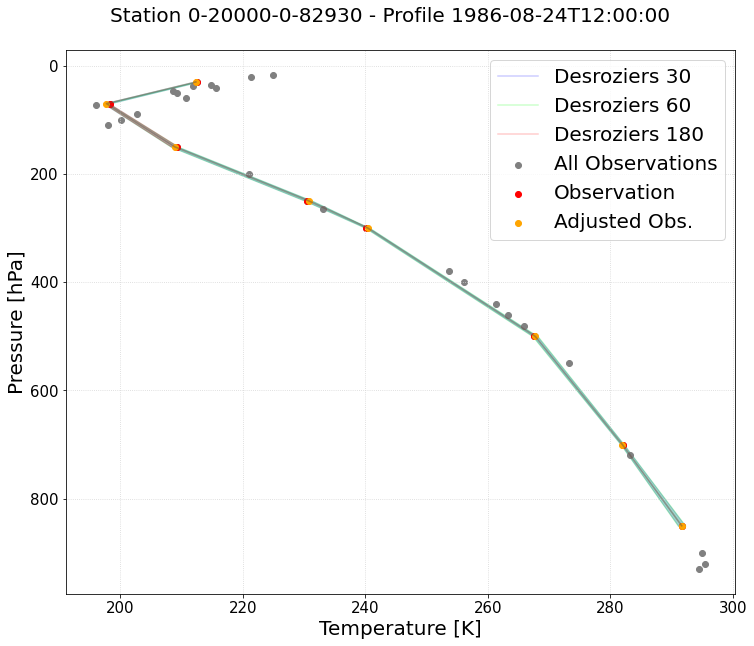

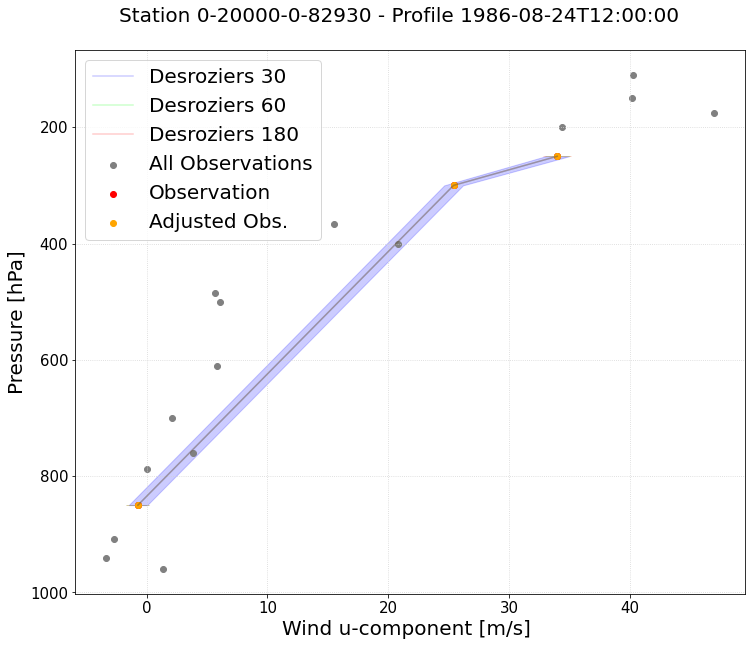

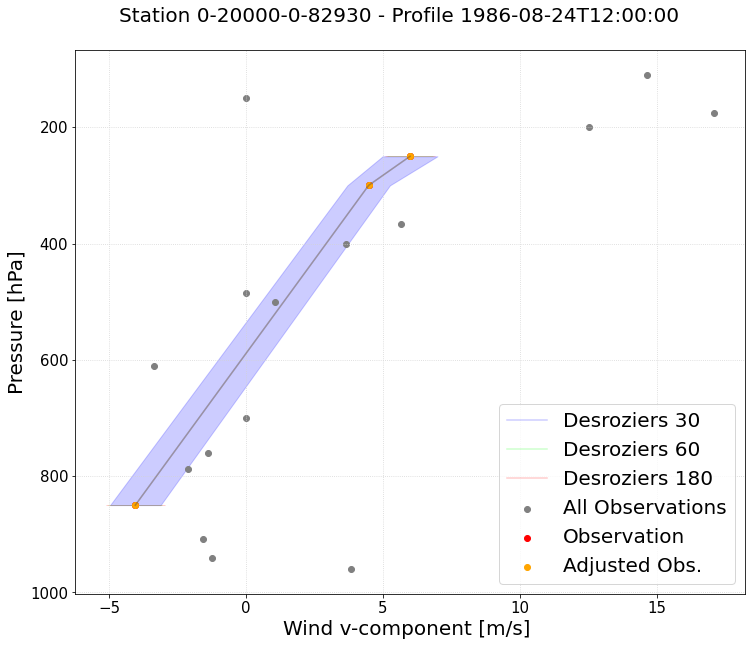

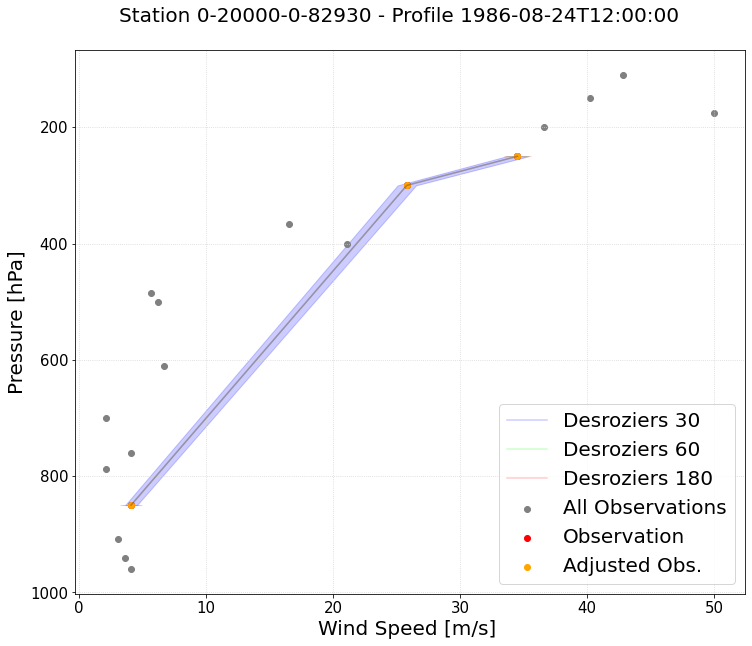

In [34]:
profile = plot_profile(df_in=DF, date=DATE, station=STATION, vars = [85, 104,105,107], zoom = False )